## Tên đề tài: Dự đoán thị trường chứng khoán bằng các phương pháp học máy

Trong đề tài này chúng ta sẽ sử dụng 2 phương pháp máy học:

- **Hồi quy tuyến tính (Linear Regression)**: Hồi quy tuyến tính là một phương pháp thống kê dùng để dự đoán giá trị của một biến phụ thuộc (biến đầu ra) dựa trên giá trị của một hoặc nhiều biến độc lập (biến đầu vào) bằng cách tìm ra đường thẳng tốt nhất (hàm tuyến tính) phù hợp với dữ liệu.

- **LSTM (Long Short-Term Memory)**: LSTM là một loại mạng nơ-ron hồi quy sâu (RNN) có khả năng ghi nhớ thông tin trong thời gian dài, được thiết kế để giải quyết vấn đề biến mất và bùng nổ gradient, rất hiệu quả trong việc xử lý và dự đoán chuỗi thời gian phức tạp như giá cổ phiếu.

# Import các thư viện

In [3]:
from vnstock import *
import os
import pandas as pd
import numpy as np

**Vui lòng chuyển đổi sang Vnstock3** thế hệ mới (0.3.0.7) với câu lệnh: `pip install vnstock3 --upgrade`.
**Từ 1/1/2025, vnstock3 sẽ được cài đặt khi sử dụng cú pháp** `pip install vnstock` **thay cho Vnstock Legacy** hiện tại.
Xem chi tiết [chuyển đổi sang vnstock3](https://vnstocks.com/docs/tai-lieu/migration-chuyen-doi-sang-vnstock3).
Phiên bản **Vnstock Legacy (0.2.9.2.2)** bạn đang sử dụng **sẽ không được nâng cấp thêm.**


In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense


# Chuẩn bị dữ liệu

- Chúng ta sẽ sử dụng thư viện "vnstock" (Vietnamese Stock Library). Đây là một thư viện Python phổ biến cho việc tải dữ liệu về giá cổ phiếu, chỉ số, tin tức, và các thông tin khác liên quan đến thị trường chứng khoán Việt Nam.

In [6]:
# cài đặt thư viện nếu chưa có
!pip install vnstock

**Ở thư viện vnstock có nhiều loại cổ phiếu thuộc nhiều ngành khác nhau. Em đề xuất chọn cổ phiếu thuộc ngành ngân hàng vì những lí do sau:**

-  Ngân hàng thường hoạt động trong nhiều lĩnh vực, bao gồm cho vay, tiền gửi, dịch vụ tài chính, bảo hiểm, và đầu tư. Do đó, cổ phiếu của ngân hàng có thể phản ánh tương đối rộng rãi xu hướng kinh tế và tài chính.

-  Ngân hàng là một phần quan trọng của hệ thống tài chính và có thể có ảnh hưởng lớn đến thị trường chứng khoán. Những quyết định và hoạt động của ngân hàng có thể tác động đến giá cổ phiếu của chính họ cũng như các doanh nghiệp khác.


**Các ngân hàng Big 4 ở Việt Nam bao gồm:**

- Ngân hàng Nông nghiệp và Phát triển nông thôn (Agribank)

- Ngân hàng Thương mại Cổ phần Đầu tư và Phát triển Việt Nam (BIDV)

- Ngân hàng Công thương Việt Nam (Vietinbank)

- Ngân hàng Thương mại Cổ phần Ngoại thương Việt Nam (Vietcombank)
> Chúng ta sẽ cùng nhau dự đoán thị trường chứng khoán Việt Nam thông qua một trong những cổ phiếu ngành ngân hàng thuộc 'Big 4' ngân hàng ở Việt Nam là **Ngân hàng Thương mại Cổ phần Ngoại thương Việt Nam (Vietcombank)**

**Mã chứng khoán của 4 ngân hàng trên thư viện vnstock như sau:**
- AGR: Agribank
- BID: BIDV
- CTG: Vietinbank
- VCB: Vietcombank

In [7]:
path = "stock-historical-data"
if not os.path.exists(path):
    os.makedirs(path)

# Mã chứng khoán của 4 ngân hàng
ticker = ["AGR", "BID", "CTG", "VCB"]

# Lặp qua các mã ngân hàng và lấy dữ liệu
for i, tick in enumerate(ticker):
    try:
        print(f"{i} {tick}")
        # Lấy dữ liệu từ 20-05-2019 đến 20-05-2024
        df_stock_historical_data = stock_historical_data(
            symbol=tick, start_date="2019-05-20", end_date="2024-05-20")

        # Tạo tên file CSV và lưu dữ liệu vào file CSV ở đường dẫn trên
        csv_file_name = f"stock-historical-data/{tick}-History.csv"
        df_stock_historical_data.to_csv(csv_file_name, encoding="utf-8-sig")
    except:
        print("Crawling failed:", tick)

0 AGR
1 BID
2 CTG
3 VCB


In [8]:
# Đọc dữ liệu
AGR = pd.read_csv('stock-historical-data\AGR-History.csv')
BID = pd.read_csv('stock-historical-data\BID-History.csv')
CTG = pd.read_csv('stock-historical-data\CTG-History.csv')
VCB = pd.read_csv('stock-historical-data\VCB-History.csv')

In [9]:
# Xem dữ liệu
VCB

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2019-05-20,43070,43910,43010,43710,607060,VCB
1,1,2019-05-21,43780,44100,43650,43650,473170,VCB
2,2,2019-05-22,43330,44230,43200,43330,662700,VCB
3,3,2019-05-23,43460,43840,43260,43590,378440,VCB
4,4,2019-05-24,43390,43840,42620,42880,931250,VCB
...,...,...,...,...,...,...,...,...
1248,1248,2024-05-14,91100,91600,90500,90600,818400,VCB
1249,1249,2024-05-15,91000,91300,90800,91000,883100,VCB
1250,1250,2024-05-16,92000,92700,91500,92600,1713900,VCB
1251,1251,2024-05-17,92600,92600,91700,91800,1084700,VCB


# Tiền xử lý
**Loại bỏ những cột không cần thiết**

In [10]:
bank_list = [AGR, BID, CTG, VCB]

# Xóa cột 'Unnamed: 0' và 'ticker'
for i in range(len(bank_list)):
    bank_list[i] = bank_list[i].drop(columns=['Unnamed: 0'])
    bank_list[i] = bank_list[i].drop(columns=['ticker'])
    bank_list[i]['time'] = pd.to_datetime(bank_list[i]['time'])
    # bank_list[i].set_index('time',inplace=True)

AGR, BID, CTG, VCB = bank_list

In [11]:
# Hiển thị 10 dòng đầu của AGR
VCB.head(10)

,time,open,high,low,close,volume
0,2019-05-20,43070,43910,43010,43710,607060
1,2019-05-21,43780,44100,43650,43650,473170
2,2019-05-22,43330,44230,43200,43330,662700
3,2019-05-23,43460,43840,43260,43590,378440
4,2019-05-24,43390,43840,42620,42880,931250
5,2019-05-27,43200,43710,42880,43460,341320
6,2019-05-28,43200,44230,43070,43460,664400
7,2019-05-29,43590,43910,43330,43520,313510
8,2019-05-30,43520,43910,43390,43650,320900
9,2019-05-31,43520,43840,43070,43330,712090


**Giải thích ý nghĩa tên các cột:**
- time: Ngày giao dịch. Đây là cột chỉ ra ngày cụ thể mà các giao dịch này đã diễn ra, theo định dạng năm-tháng-ngày (YYYY-MM-DD).
- open: Giá mở cửa. Đây là mức giá đầu tiên được giao dịch vào ngày đó.
- high: Giá cao nhất. Đây là mức giá cao nhất mà cổ phiếu được giao dịch trong ngày.
- low: Giá thấp nhất. Đây là mức giá thấp nhất mà cổ phiếu được giao dịch trong ngày.
- close: Giá đóng cửa. Đây là mức giá cuối cùng được giao dịch vào ngày đó.
- volume: Khối lượng giao dịch. Đây là tổng số lượng cổ phiếu được giao dịch trong ngày.


> Ta thấy dữ liệu chỉ có thông tin 5 ngày/tuần(T2-T6) vì sàn giao dịch chứng khoán quy định ngày giao dịch từ thứ 2 đến thứ 6 trừ thứ 7, CN và Lễ theo quy định chung

In [12]:
VCB

,time,open,high,low,close,volume
0,2019-05-20,43070,43910,43010,43710,607060
1,2019-05-21,43780,44100,43650,43650,473170
2,2019-05-22,43330,44230,43200,43330,662700
3,2019-05-23,43460,43840,43260,43590,378440
4,2019-05-24,43390,43840,42620,42880,931250
...,...,...,...,...,...,...
1248,2024-05-14,91100,91600,90500,90600,818400
1249,2024-05-15,91000,91300,90800,91000,883100
1250,2024-05-16,92000,92700,91500,92600,1713900
1251,2024-05-17,92600,92600,91700,91800,1084700


In [13]:
# Kiểm tra xem lễ 30/4 có dữ liệu không
date = '30-4-2019'
data = VCB.loc[VCB['time'] ==  date]
data

,time,open,high,low,close,volume


> Ta thấy không có dữ liệu vào 30/4

# EDA (Khám phá dữ liệu)

**Thống kê mô tả dữ liệu**
- .describe() dùng để xem các thống kê mô tả. Thống kê mô tả bao gồm các thống kê tóm tắt về số lượng mẫu, trung bình, độ lệch chuẩn và hình dạng của phân phối dữ liệu.

In [14]:
VCB.describe().T

,count,mean,min,25%,50%,75%,max,std
time,1253,2021-11-13 07:09:48.986432512,2019-05-20 00:00:00,2020-08-13 00:00:00,2021-11-11 00:00:00,2023-02-15 00:00:00,2024-05-20 00:00:00,NaN
open,1253.0,66974.542698,37210.0,56530.0,64930.0,76210.0,98500.0,13513.585
high,1253.0,67729.00399,37990.0,57060.0,65489.0,77140.0,100500.0,13562.754813
low,1253.0,66229.066241,36820.0,55840.0,64010.0,75360.0,97300.0,13415.150301
close,1253.0,67016.932163,37210.0,56530.0,64930.0,76210.0,97400.0,13487.722706
volume,1253.0,1147215.219473,113900.0,725310.0,1025700.0,1433230.0,6274200.0,628084.386881


**Thông tin về dữ liệu**
- Phương thức .info() in ra thông tin về một DataFrame bao gồm kiểu dữ liệu và các cột, số lượng giá trị không bị thiếu.

In [15]:
VCB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1253 non-null   datetime64[ns]
 1   open    1253 non-null   int64         
 2   high    1253 non-null   int64         
 3   low     1253 non-null   int64         
 4   close   1253 non-null   int64         
 5   volume  1253 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 58.9 KB


In [16]:
print(VCB.isnull().sum())

time      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


> Ta thấy dữ liệu không bị thiếu

**Trực quan hóa**

In [17]:
df = VCB.copy()
df.set_index('time',inplace=True)
df

,open,high,low,close,volume
time,,,,,
2019-05-20,43070,43910,43010,43710,607060
2019-05-21,43780,44100,43650,43650,473170
2019-05-22,43330,44230,43200,43330,662700
2019-05-23,43460,43840,43260,43590,378440
2019-05-24,43390,43840,42620,42880,931250
...,...,...,...,...,...
2024-05-14,91100,91600,90500,90600,818400
2024-05-15,91000,91300,90800,91000,883100
2024-05-16,92000,92700,91500,92600,1713900


In [18]:
# Trực quan hóa bằng biểu đồ nến về các thuộc tính giá và khối lượng giao dịch
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02, row_heights=[0.7, 0.3])
candlestick = go.Candlestick(x=df.index,
                             open=df['open'],
                             high=df['high'],
                             low=df['low'],
                             close=df['close'],
                             name='Các thuộc tính giá')
fig.add_trace(candlestick, row=1, col=1)

volume = go.Bar(x=df.index, y=df['volume'], name='Khối lượng giao dịch', marker=dict(color='blue'))
fig.add_trace(volume, row=2, col=1)

fig.update_layout(title='Biểu đồ nến về các thuộc tính giá và khối lượng giao dịch',
                  yaxis_title='Giá',
                  yaxis2_title='Khối lượng giao dịch',
                  xaxis2_title='Thời gian',
                  xaxis_rangeslider_visible=False)
fig.show()

In [19]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

fig = make_subplots(rows=5, cols=1,
                    subplot_titles=("Giá mở cửa", "Giá đóng cửa", "Giá cao nhất", "Giá thấp nhất", "Khối lượng giao dịch"))
fig.add_trace(go.Scatter(x=df.index, y=df["open"]), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["close"]), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["high"]), row=3, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["low"]), row=4, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["volume"]), row=5, col=1)
fig.update_layout(showlegend=False, height=1200, width=800)
fig.show()

**Nhận xét:**

- Trong khoảng thời gian từ 2019 đến 2024, giá có xu hướng tăng lên tổng thể. Mặc dù có những giai đoạn giá điều chỉnh và giảm, xu hướng chung là đi lên.

- Biểu đồ cho thấy nhiều giai đoạn biến động mạnh, Các giai đoạn có biến động giá mạnh ta có thể thấy như vào khoảng tháng 4/2020 giá chạm đấy,  tháng 1/2022 thì giá tăng liên tục.

- Có thể thấy rằng khối lượng giao dịch tăng mạnh ở một số thời điểm, đặc biệt là tháng 4/2021 khối lượng tăng rất mạnh.

- Điểm đảo chiều rõ ràng có thể thấy được, vào tháng 10/2020 khi giá giảm mạnh rồi sau đó tăng trở lại.

- Tình hình hiện tại giá vẫn đang trong xu hướng tăng và đạt các mức cao mới, cho thấy thị trường có thể đang trong giai đoạn tăng trưởng.

**Mức độ tương quan giữa các thuộc tính**

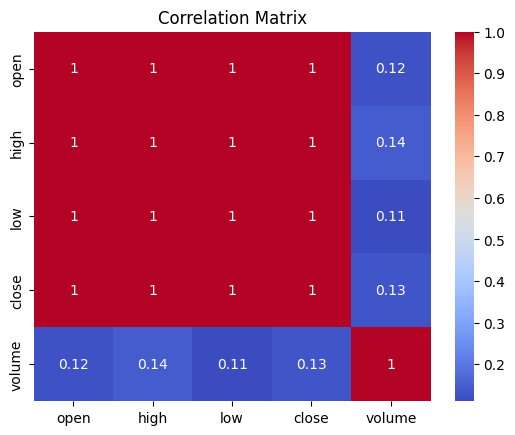

In [20]:
df = VCB[['open', 'high', 'low','close','volume']]
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

**Nhận xét**

- Các thuộc tính open, high, low, và close có mối tương quan rất cao với nhau (hệ số tương quan bằng 1). Điều này cho thấy giá mở cửa, giá cao nhất, giá thấp nhất và giá đóng cửa thường thay đổi đồng thời và có xu hướng tương tự nhau trong suốt phiên giao dịch.

- volume có mối tương quan thấp hơn với các thuộc tính liên quan tới giá. Khối lượng giao dịch là một yếu tố bổ sung quan trọng, nhưng không phải là yếu tố quyết định hoàn toàn giá cổ phiếu. Nó cung cấp thông tin về mức độ quan tâm của thị trường đối với cổ phiếu tại thời điểm cụ thể.

# **Dùng mô hình  dự đoán**

## **I. Linear Regression**

In [21]:
df = VCB.copy()
df

,time,open,high,low,close,volume
0,2019-05-20,43070,43910,43010,43710,607060
1,2019-05-21,43780,44100,43650,43650,473170
2,2019-05-22,43330,44230,43200,43330,662700
3,2019-05-23,43460,43840,43260,43590,378440
4,2019-05-24,43390,43840,42620,42880,931250
...,...,...,...,...,...,...
1248,2024-05-14,91100,91600,90500,90600,818400
1249,2024-05-15,91000,91300,90800,91000,883100
1250,2024-05-16,92000,92700,91500,92600,1713900
1251,2024-05-17,92600,92600,91700,91800,1084700


**Lựa chọn đặc trưng để dự đoán**
- Trong số 5 thuộc tính của cổ phiếu chúng ta sẽ chọn 4 thuộc tính 'open', 'high', 'low', 'volume' làm đặc trưng để dự đoán **'close'**. Lý do chính là: Giá đóng cửa thường được coi là một chỉ số quan trọng trong phân tích kỹ thuật và dự đoán giá cổ phiếu. Nó phản ánh giá cuối cùng mà cổ phiếu được giao dịch trong một ngày giao dịch. Do đó, nó có thể chứa nhiều thông tin về xu hướng và biến động giá trong ngày.

In [22]:
features = ['open', 'high', 'low', 'volume']  
target = ['close']

**Chia tập train/test**

In [23]:
train_data = df.iloc[:int(.8*len(df)), :]
test_data = df.iloc[int(.8*len(df)):, :]

In [24]:
train_data

,time,open,high,low,close,volume
0,2019-05-20,43070,43910,43010,43710,607060
1,2019-05-21,43780,44100,43650,43650,473170
2,2019-05-22,43330,44230,43200,43330,662700
3,2019-05-23,43460,43840,43260,43590,378440
4,2019-05-24,43390,43840,42620,42880,931250
...,...,...,...,...,...,...
997,2023-05-11,77900,77980,77050,77140,459000
998,2023-05-12,77050,78240,76880,78240,602400
999,2023-05-15,77900,78750,77220,78070,418500
1000,2023-05-16,77900,78830,77310,78320,647700


> Train data là khoảng 80% dòng đầu dữ liệu(1002 dòng)

In [25]:
test_data

,time,open,high,low,close,volume
1002,2023-05-18,78660,81290,78070,80780,1434300
1003,2023-05-19,80020,80360,78410,79510,416900
1004,2023-05-22,78750,79510,78070,78830,544900
1005,2023-05-23,78750,79250,77980,78150,535100
1006,2023-05-24,78580,78580,77820,78410,342200
...,...,...,...,...,...,...
1248,2024-05-14,91100,91600,90500,90600,818400
1249,2024-05-15,91000,91300,90800,91000,883100
1250,2024-05-16,92000,92700,91500,92600,1713900
1251,2024-05-17,92600,92600,91700,91800,1084700


> Test data là 20% dữ liệu còn lại(251 dòng)

In [26]:
X_train, X_test, y_train, y_test = train_data[features], test_data[features], train_data[target], test_data[target]

**Tạo và huấn luyện mô hình Linear Regression**

In [27]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [28]:
# Dự đoán với dữ liệu tập kiểm tra
y_pred = model_lr.predict(X_test)

In [29]:
# Hiển thị giá dự đoán và giá thực tế bằng dataframe
y_pred_df = pd.DataFrame(y_pred, index=range(1002, 1002+len(y_pred)), columns=['y_pred'])
result_df = pd.concat([y_test, y_pred_df], axis=1)
result_df

,close,y_pred
1002,80780,80229.934925
1003,79510,79236.930884
1004,78830,78829.439687
1005,78150,78574.180616
1006,78410,78024.184128
...,...,...
1248,90600,90996.508468
1249,91000,90968.307959
1250,92600,92082.632431
1251,91800,91921.897135


In [30]:
# Trực quan hóa so sánh giá dự đoán và giá thực tế
result_df = test_data.copy()
result_df['Predicted Close'] = y_pred

fig = go.Figure()
fig.add_trace(go.Scatter(x=result_df['time'], y=result_df['close'], mode='lines', name='Giá đóng cửa thực tế'))
fig.add_trace(go.Scatter(x=result_df['time'], y=result_df['Predicted Close'], mode='lines', name='Giá đóng cửa dự đoán'))

fig.update_layout(
    title='Biểu đồ so sánh giá đóng cửa dự đoán và giá đóng cửa thực tế',
    xaxis_title='Thời gian',
    yaxis_title='Giá',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1 tháng', step='month', stepmode='backward'),
                dict(count=6, label='6 tháng', step='month', stepmode='backward'),
                dict(label='Tất cả',step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    )
)

fig.show()

In [31]:
# Trực quan hóa sai số dự đoán
# Sai số dự đoán = Kết quả thực tế - Kết quả dự đoán
result_df['Prediction Error'] = result_df['close'] - result_df['Predicted Close']

fig = go.Figure()
fig.add_trace(go.Bar(x=result_df['time'], y=result_df['Prediction Error'], name='Prediction Error'))
fig.add_shape(type='line', x0=result_df['time'].min(), y0=0, x1=result_df['time'].max(), y1=0,
              line=dict(color='red', dash='dash'))

fig.update_layout(
    title='Sai số dự đoán của mô hình',
    xaxis_title='Thời gian',
    yaxis_title='Sai số dự đoán',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1 tháng', step='month', stepmode='backward'),
                dict(count=6, label='6 tháng', step='month', stepmode='backward'),
                dict(label='Tất cả',step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    ),
    shapes=[
        dict(
            type='line',
            x0=result_df['time'].min(),
            x1=result_df['time'].max(),
            y0=0,
            y1=0,
            line=dict(color='red', width=2, dash='dash')
        )
    ]
)

fig.show()

In [32]:
# Đánh giá mô hình
r2_lr = r2_score(y_test, y_pred)
mae_lr = mean_absolute_error(y_test, y_pred)

print(f'R^2 Score: {r2_lr}')
print(f'Mean Absolute Error (MAE): {mae_lr}')

R^2 Score: 0.9829017527878826
Mean Absolute Error (MAE): 423.3299067452862


> Với R² Score của mô hình là 0.9829, mô hình đã giải thích được 98.29% biến thiên của dữ liệu. Đây là một giá trị rất cao, ta thấy được mô hình rất phù hợp với dữ liệu

> MAE đo lường giá trị trung bình của sai số tuyệt đối giữa giá trị thực tế và giá trị dự đoán. MAE của chúng ta là 423.33, so với phạm vi của biến 'close' ta thấy sai số khá nhỏ.

## **Hoàn thành mô hình Linear Regression, tiếp đến là mô hình LSTM**

## **II.LSTM**

In [33]:
df = VCB.copy()
df

,time,open,high,low,close,volume
0,2019-05-20,43070,43910,43010,43710,607060
1,2019-05-21,43780,44100,43650,43650,473170
2,2019-05-22,43330,44230,43200,43330,662700
3,2019-05-23,43460,43840,43260,43590,378440
4,2019-05-24,43390,43840,42620,42880,931250
...,...,...,...,...,...,...
1248,2024-05-14,91100,91600,90500,90600,818400
1249,2024-05-15,91000,91300,90800,91000,883100
1250,2024-05-16,92000,92700,91500,92600,1713900
1251,2024-05-17,92600,92600,91700,91800,1084700


**Lựa chọn đặc trưng để dự đoán**

- Với mô hình LSTM nếu ta chọn 'close' là biến mục tiêu để dự đoán thì ta cần chính 'close' làm biến mục tiêu

**Chia tập train/test**

- Khác mô hình Linear Regression, chúng ta sẽ Dùng 50 ngày liên tục làm cơ sở dự đoán của ngày tiếp theo, nên không cần chia train/test

- VD: Từ ngày 1 đến ngày 50 sẽ dùng dự đoán cho ngày 51; Từ ngày 2 đến ngày 51 sẽ dùng dự đoán cho ngày 52; ... Tương tự như vậy cho đến hết tập dữ liệu train

In [34]:
train_data = pd.DataFrame(df, columns=['time', 'close'])
train_data

,time,close
0,2019-05-20,43710
1,2019-05-21,43650
2,2019-05-22,43330
3,2019-05-23,43590
4,2019-05-24,42880
...,...,...
1248,2024-05-14,90600
1249,2024-05-15,91000
1250,2024-05-16,92600
1251,2024-05-17,91800


**Xử lý dữ liệu trước khi huấn luyện mô hình**
- Chuẩn hóa dữ liệu, chuyển dữ liệu thành mảng và reshape dữ liệu là một bước cần thiết trước khi đem dữ liệu vào mô hình LSTM

In [35]:
# Chuẩn hóa dữ liệu
train_data_values = train_data['close'].values.reshape(-1, 1)
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(train_data_values)

# Dùng 50 ngày liên tục làm cơ sở dự đoán của ngày tiếp theo
x_train, y_train, times = [], [], []
for i in range(50, len(train_data_values)):
    x_train.append(sc_train[i-50:i, 0])
    y_train.append(sc_train[i, 0])
    times.append(train_data['time'].values[i])
    
# Chuyển đổi dữ liệu thành mảng numpy
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape dữ liệu
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

**Tạo và huấn luyện mô hình LSTM**

In [36]:
# Xây dựng mô hình LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=128, input_shape=(x_train.shape[1], 1), return_sequences=True))
model_lstm.add(LSTM(units=64))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_absolute_error', optimizer='adam')
model_lstm.fit(x_train, y_train, epochs=10, batch_size=50, verbose=2)


Epoch 1/10


c:\Users\vinhl\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



25/25 - 4s - 151ms/step - loss: 0.1429
Epoch 2/10
25/25 - 1s - 57ms/step - loss: 0.0776
Epoch 3/10
25/25 - 1s - 59ms/step - loss: 0.0689
Epoch 4/10
25/25 - 2s - 91ms/step - loss: 0.0697
Epoch 5/10
25/25 - 1s - 45ms/step - loss: 0.0686
Epoch 6/10
25/25 - 1s - 50ms/step - loss: 0.0659
Epoch 7/10
25/25 - 1s - 48ms/step - loss: 0.0613
Epoch 8/10
25/25 - 1s - 45ms/step - loss: 0.0624
Epoch 9/10
25/25 - 1s - 44ms/step - loss: 0.0690
Epoch 10/10
25/25 - 1s - 50ms/step - loss: 0.0624


In [37]:
# Dự đoán trên tập huấn luyện
y_predict = model_lstm.predict(x_train)
y_train = sc.inverse_transform(y_train)
y_predict = sc.inverse_transform(y_predict)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [38]:
# Hiển thị giá dự đoán và giá thực tế bằng dataframe
results_df = pd.DataFrame({'time': times, 'Giá thực tế': y_train.flatten(), 'Giá dự đoán': y_predict.flatten()})
results_df

,time,Giá thực tế,Giá dự đoán
0,2019-07-29,52230.0,49720.328125
1,2019-07-30,51970.0,49955.980469
2,2019-07-31,51710.0,50206.265625
3,2019-08-01,51900.0,50432.703125
4,2019-08-02,51000.0,50639.046875
...,...,...,...
1198,2024-05-14,90600.0,86483.765625
1199,2024-05-15,91000.0,86367.921875
1200,2024-05-16,92600.0,86220.179688
1201,2024-05-17,91800.0,86172.468750


In [39]:
# Trực quan hóa so sánh giá dự đoán và giá thực tế
times_str = [str(time) for time in times]

fig = go.Figure()
fig.add_trace(go.Scatter(x=times_str, y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=times_str, y=y_predict.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='red')))

fig.update_layout(
    title='Biểu đồ so sánh giá đóng cửa dự đoán và giá đóng cửa thực tế',
    xaxis_title='Thời gian',
    yaxis_title='Giá',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1 tháng', step='month', stepmode='backward'),
                dict(count=6, label='6 tháng', step='month', stepmode='backward'),
                dict(label='Tất cả',step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    )
)

# Show plot
fig.show()


In [40]:
# Đánh giá mô hình
r2_lstm = r2_score(y_train, y_predict)
mae_lstm = mean_absolute_error(y_train, y_predict)

print("R^2 Score", r2_lstm)
print("Mean Absolute Error (MAE):", mae_lstm)

R^2 Score 0.9145146749136865
Mean Absolute Error (MAE): 3127.9679706982542


**Chúng ta se thử dự đoán 5 ngày tiếp theo ngoài bộ dữ liệu**
- Chúng ta sẽ 50 ngày cuối cùng trong tập huấn luyện từ đó dự đoán được ngày kế tiếp

In [41]:
# Dự đoán 5 ngày tiếp theo
future_days = 5
last_50_days = sc_train[-50:]  # Lấy 50 ngày cuối cùng trong tập huấn luyện
predicted_future = []
train_data = last_50_days.copy()

for _ in range(future_days):
    # Dự đoán giá ngày tiếp theo
    train_data_reshaped = np.reshape(train_data, (1, train_data.shape[0], 1))
    next_day_prediction = model_lstm.predict(train_data_reshaped)
    
    # Chuyển đổi giá trị dự đoán về dạng gốc
    next_day_prediction_inversed = sc.inverse_transform(next_day_prediction)
    
    # Thêm giá trị dự đoán vào danh sách kết quả
    predicted_future.append(next_day_prediction_inversed[0, 0])
    
    # Thêm giá trị dự đoán vào train_data và loại bỏ giá trị đầu tiên
    train_data = np.append(train_data[1:], next_day_prediction, axis=0)

# Hiển thị giá dự đoán cho 5 ngày tiếp theo
predicted_future = np.array(predicted_future)
print("Dự đoán giá cho 5 ngày tiếp theo:", predicted_future)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Dự đoán giá cho 5 ngày tiếp theo: [86116.09 85715.91 85090.97 84326.55 83481.42]


In [42]:
last_time = pd.to_datetime(results_df['time'].iloc[-1])
future_times = [last_time + pd.Timedelta(days=i) for i in range(1, future_days + 1)]
future_df = pd.DataFrame({'time': future_times, 'Giá 5 ngày tiếp theo': predicted_future})
results_df = pd.concat([results_df, future_df], ignore_index=True)
results_df

,time,Giá thực tế,Giá dự đoán,Giá 5 ngày tiếp theo
0,2019-07-29,52230.0,49720.328125,NaN
1,2019-07-30,51970.0,49955.980469,NaN
2,2019-07-31,51710.0,50206.265625,NaN
3,2019-08-01,51900.0,50432.703125,NaN
4,2019-08-02,51000.0,50639.046875,NaN
...,...,...,...,...
1203,2024-05-21,NaN,NaN,86116.093750
1204,2024-05-22,NaN,NaN,85715.906250
1205,2024-05-23,NaN,NaN,85090.968750
1206,2024-05-24,NaN,NaN,84326.546875


In [43]:
# Vẽ biểu đồ thể hiện kết quả dự đoán 5 ngày tiếp theo
# Lọc dữ liệu từ 5/2024 trở đi
start_date = pd.to_datetime('2024-01-01')
results_df1 = results_df[results_df['time'] >= start_date]

# Vẽ biểu đồ thể hiện kết quả dự đoán 5 ngày tiếp theo
fig = make_subplots()

fig.add_trace(go.Scatter(
    x=results_df1['time'],
    y=results_df1['Giá thực tế'],
    mode='lines',
    name='Giá thực tế',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=results_df1['time'],
    y=results_df1['Giá dự đoán'],
    mode='lines',
    name='Giá dự đoán',
    line=dict(color='red')
))

# Chỉ thêm dữ liệu tương lai nếu có trong results_df1
if 'Giá 5 ngày tiếp theo' in results_df1.columns:
    fig.add_trace(go.Scatter(
        x=results_df1['time'],
        y=results_df1['Giá 5 ngày tiếp theo'],
        mode='lines',
        name='Giá 5 ngày tiếp theo',
        line=dict(color='green', dash='dash')
    ))

fig.update_layout(
    title='Biểu đồ thể hiện kết quả dự đoán 5 ngày tiếp theo',
    xaxis_title='Thời gian',
    yaxis_title='Giá đóng cửa',
    legend=dict(x=0, y=1),
)

fig.show()

> Dựa vào kết quả dự đoán ta thấy xu hướng giá sẽ tăng trong 5 ngày tiếp theo

# **So sánh 2 phương pháp máy học đã dùng để dự đoán thị trường chứng khoán**

- Độ đo đánh giá giữa 2 mô hình:

In [44]:
metrics = {
    'Model': ['Linear Regression', 'LSTM'],
    'R^2 Score': [r2_lr, r2_lstm],
    'Mean Absolute Error (MAE)': [mae_lr, mae_lstm]
}

metrics_df = pd.DataFrame(metrics)

print(metrics_df)

               Model  R^2 Score  Mean Absolute Error (MAE)
0  Linear Regression   0.982902                 423.329907
1               LSTM   0.914515                3127.967971


#### **Ta có thể rút ra được kết luận từ bảng so sánh các độ đo ở trên như sau:**

Dựa trên các độ đo được cung cấp, ta có thể rút ra các kết luận so sánh về hai mô hình dự đoán thị trường chứng khoán bằng hai phương pháp máy học: Linear Regression (Hồi quy tuyến tính) và LSTM (Long Short-Term Memory).

- $R^2 Score$ (hệ số xác định) đo lường tỷ lệ biến thiên của dữ liệu có thể giải thích được bằng mô hình. $R^2 Score$ của Linear Regression gần bằng 1, cho thấy rằng mô hình này giải thích rất tốt biến thiên trong dữ liệu. $R^2 Score$ của LSTM cũng cao, nhưng thấp hơn so với Linear Regression, cho thấy rằng Linear Regression có khả năng giải thích biến thiên của dữ liệu tốt hơn.

- MAE đo lường trung bình giá trị tuyệt đối của các sai số dự đoán. MAE của Linear Regression nhỏ hơn rất nhiều so với LSTM, cho thấy rằng sai số trung bình của các dự đoán từ mô hình Linear Regression nhỏ hơn so với LSTM. Điều này cũng củng cố kết luận rằng Linear Regression dự đoán chính xác hơn so với LSTM.

> Dựa trên các độ đo đã phân tích ($R^2 Score$, MAE), có thể rút ra kết luận rằng mô hình Linear Regression có hiệu suất dự đoán tốt hơn mô hình LSTM trong bài toán dự đoán thị trường chứng khoán. Linear Regression có sai số nhỏ hơn và khả năng giải thích biến thiên của dữ liệu tốt hơn so với LSTM.